In [1]:
import os
import random

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy, Precision, Recall

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import vgg16

import numpy as np
import matplotlib.pyplot as plt

E0000 00:00:1722355274.424365      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:479
D0730 16:01:14.433004336      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D0730 16:01:14.433024493      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D0730 16:01:14.433027985      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D0730 16:01:14.433030401      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D0730 16:01:14.433032721      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defa

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1722355288.615186      13 service.cc:145] XLA service 0x5714a330e610 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722355288.615243      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1722355288.615248      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1722355288.615251      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1722355288.615254      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1722355288.615257      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1722355288.615259      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1722355288.615262      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1722355288.615264      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [3]:
# strategy = tf.distribute.MirroredStrategy()

# Custom F1Score class
### Normal tensorflow F1Score is not supported here like google colab

In [4]:
from tensorflow.keras.metrics import Metric

class F1Score(Metric):
    def __init__(self, name='f1score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


In [5]:
dataset_base_path = '/kaggle/input/book-and-notebook'
db_name = '/kaggle/input/book-and-notebook/dataset_256'

# Hyper Parameters

In [79]:
batch_size = 32
image_size = (256, 256)
learning_rate = 1e-4
lr_decay_factor = 0.09
epochs=50
label_mode = 'int'
seed=42
train_ds_size=1000
val_ds_size=400

In [80]:
# print('Replicas: ',strategy.num_replicas_in_sync)

# Batch size when using GPU

In [81]:
# batch_size = strategy.num_replicas_in_sync * 8

# Batch size when using TPU

In [82]:
batch_size = strategy.num_replicas_in_sync * 4

# Setting up random seed for deterministic output

In [83]:
tf.random.set_seed(seed)

global_generator = tf.random.Generator.from_seed(seed)
tf.random.set_global_generator(global_generator)

np.random.seed(seed)
random.seed(seed)
AUTOTUNE = tf.data.AUTOTUNE

In [84]:
print(batch_size)

32


# Reading train, validation and test dataset

In [85]:
train_ds = keras.utils.image_dataset_from_directory(
    f'{db_name}/train',
    image_size=image_size,
    batch_size=batch_size,
    label_mode=label_mode,
    shuffle=True,
)

val_ds = keras.utils.image_dataset_from_directory(
    f'{db_name}/valid',
    image_size=image_size,
    batch_size=batch_size,
    label_mode=label_mode,
    shuffle=False,
)

test_ds = keras.utils.image_dataset_from_directory(
    f'{db_name}/test',
    image_size=image_size,
    batch_size=batch_size,
    label_mode=label_mode,
    shuffle=False,
)


# test_ds = test_ds.map(lambda x, y: (tf.cast(x, tf.float16), tf.cast(y, tf.uint8)))
# test_ds = test_ds.map(lambda x, y: (x, tf.cast(y, tf.int32)))

# Used for plotting
class_names = train_ds.class_names

Found 782 files belonging to 2 classes.
Found 106 files belonging to 2 classes.
Found 160 files belonging to 2 classes.


In [86]:
# # train_ds.map(lambda image, label: image)
# train_ds = train_ds.map(lambda x, y: (tf.cast(x, tf.float16), tf.cast(y, tf.uint8)))
# val_ds = val_ds.map(lambda x, y: (tf.cast(x, tf.float16), tf.cast(y, tf.uint8)))
# train_ds = train_ds.map(lambda x, y: (x, tf.cast(y, tf.int32)))
# val_ds = val_ds.map(lambda x, y: (x, tf.cast(y, tf.int32)))

# plot function

In [87]:
# def show(ds):
#   for imgs, labels in ds:
#     break
#   info = []
#   for i in range(12):
#     info.append((labels[i], i))
#   info.sort()

#   plt.figure(figsize=(10, 4))
#   # plt.suptitle('Dataset samples', fontsize=20)
#   for i in range(12):
#     plt.subplot(2,6,i+1)
#     plt.imshow(imgs[info[i][1]] / 255)
#     plt.axis('off')
#     plt.title('{}'.format(labels[info[i][1]]))

#   # plt.savefig("./{}.png".format('dataset-samples'), bbox_inches='tight', format='png', dpi=256)
#   plt.show();

def plot_images(dataset, title, n_images=20):
    dataset.shuffle(buffer_size=100000).prefetch(AUTOTUNE)
    dataset_iter = iter(dataset)
    images, labels = next(dataset_iter)
    plt.figure(figsize=(12, 8))
    n_images = min(n_images, len(images))
    for i in range(n_images):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i].numpy()))
        plt.axis("off")
    plt.suptitle(title)
    # plt.savefig("./{}.png".format('dataset-samples'), bbox_inches='tight', format='png', dpi=256)
    plt.show()


# Checking if an image is blackish or not

In [88]:
def is_blackish(image, threshold=80.0):
    # Convert the image to grayscale
    grayscale_image = tf.image.rgb_to_grayscale(image)
    
    # Calculate the mean brightness
    mean_brightness = tf.reduce_mean(grayscale_image).numpy()
#     print(mean_brightness)
    # Check if the mean brightness is below the threshold
    return mean_brightness < threshold

# Photometric augmentation functions

In [89]:
def adjust_contrast(image):
    return tf.image.adjust_contrast(image, contrast_factor=1.1)

def adjust_brightness(image):
    return tf.image.adjust_brightness(image, delta=100.0)

def adjust_saturation(image):
    return tf.image.adjust_saturation(image, saturation_factor=2)

def adjust_gamma(image):
    return tf.image.adjust_gamma(image, gamma=1.001)

def adjust_hue(image):
    return tf.image.adjust_hue(image, 0.12)

# Applying photometric functions

In [90]:
def combined_preprocessing(image):
    choice = np.random.choice(['saturation', 'contrast', 'hue', 'gamma'])
    
    if is_blackish(image):
        image = adjust_brightness(image)
#     return image
#     image = adjust_saturation(image)
    
    if choice == 'contrast':
        image = adjust_contrast(image)
    elif choice == 'gamma':
        image = adjust_gamma(image)
    elif choice == 'hue':
        image = adjust_hue(image)
    elif choice == 'saturation':
        image = adjust_saturation(image)
    return image

# Generating geometric augmented images

In [91]:
# geodatagen = ImageDataGenerator(rotation_range=35,
#         shear_range=0.20,
#         zoom_range=0.50,
#         horizontal_flip=True,
#         fill_mode='nearest')
zoomDataGen = ImageDataGenerator(zoom_range=0.50, fill_mode='nearest')
rotationDataGen = ImageDataGenerator(rotation_range=30, fill_mode='nearest')
shearDataGen = ImageDataGenerator(shear_range=0.20, fill_mode='nearest')
flipDataGen = ImageDataGenerator(horizontal_flip=True, fill_mode='nearest')

# Generating photometric augmented images

In [92]:
photodatagen = ImageDataGenerator(
    preprocessing_function=combined_preprocessing,
)

# Generating geometric images

In [93]:
train_generator_zoom = zoomDataGen.flow_from_directory(
    f'{db_name}/train',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary',
    classes=class_names,
    seed=seed,
)
val_generator_zoom = zoomDataGen.flow_from_directory(
    f'{db_name}/valid',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary',
    classes=class_names,
    seed=seed,
)

train_generator_rotation = rotationDataGen.flow_from_directory(
    f'{db_name}/train',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary',
    classes=class_names,
    seed=seed,
)
val_generator_rotation = rotationDataGen.flow_from_directory(
    f'{db_name}/valid',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary',
    classes=class_names,
    seed=seed,
)

train_generator_shear = shearDataGen.flow_from_directory(
    f'{db_name}/train',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary',
    classes=class_names,
    seed=seed,
)
val_generator_shear = shearDataGen.flow_from_directory(
    f'{db_name}/valid',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary',
    classes=class_names,
    seed=seed,
)


train_generator_flip = flipDataGen.flow_from_directory(
    f'{db_name}/train',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary',
    classes=class_names,
    seed=seed,
)
val_generator_flip = flipDataGen.flow_from_directory(
    f'{db_name}/valid',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary',
    classes=class_names,
    seed=seed,
)

Found 782 images belonging to 2 classes.
Found 106 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 106 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 106 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 106 images belonging to 2 classes.


# Generating photometric images

In [94]:
photo_train_generator = photodatagen.flow_from_directory(
    f'{db_name}/train',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary',
    classes=class_names,
    seed=seed,
)
photo_val_generator = photodatagen.flow_from_directory(
    f'{db_name}/valid',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary',
    classes=class_names,
    seed=seed,
)

Found 782 images belonging to 2 classes.
Found 106 images belonging to 2 classes.


In [95]:
def getImgs(gen, n):
    aug_images = []
    aug_labels = []
    for _ in range(n):
        images, labels = next(gen)
        aug_images.extend(images)
        aug_labels.extend(labels)
    
    aug_images = np.array(aug_images)
    aug_labels = np.array(aug_labels)
    return aug_images, aug_labels

# Only geometric augmented images of train data

In [96]:
images, labels = getImgs(train_generator_zoom, train_ds_size // batch_size)
new_images = []
for image in images:
#     if is_blackish(image):
#         image = adjust_brightness(image)
#     image = adjust_saturation(image)
    new_images.append(image)

images = np.array(new_images)
# images = images.astype(np.float16)
labels = labels.astype(np.int32)

aug_train = tf.data.Dataset.from_tensor_slices((images, labels)).batch(batch_size)

del images
del labels

In [97]:
train_ds = train_ds.concatenate(aug_train)

In [98]:
images, labels = getImgs(train_generator_rotation, train_ds_size // batch_size)
new_images = []
for image in images:
#     if is_blackish(image):
#         image = adjust_brightness(image)
#     image = adjust_saturation(image)
    new_images.append(image)

images = np.array(new_images)
# images = images.astype(np.float16)
labels = labels.astype(np.int32)

aug_train = tf.data.Dataset.from_tensor_slices((images, labels)).batch(batch_size)

del images
del labels

In [99]:
train_ds = train_ds.concatenate(aug_train)

In [100]:
images, labels = getImgs(train_generator_shear, train_ds_size // batch_size)
new_images = []
for image in images:
#     if is_blackish(image):
#         image = adjust_brightness(image)
#     image = adjust_saturation(image)
    new_images.append(image)

images = np.array(new_images)
# images = images.astype(np.float16)
labels = labels.astype(np.int32)

aug_train = tf.data.Dataset.from_tensor_slices((images, labels)).batch(batch_size)

del images
del labels

In [101]:
train_ds = train_ds.concatenate(aug_train)

In [102]:
images, labels = getImgs(train_generator_flip, train_ds_size // batch_size)
new_images = []
for image in images:
#     if is_blackish(image):
#         image = adjust_brightness(image)
#     image = adjust_saturation(image)
    new_images.append(image)

images = np.array(new_images)
# images = images.astype(np.float16)
labels = labels.astype(np.int32)

aug_train = tf.data.Dataset.from_tensor_slices((images, labels)).batch(batch_size)

del images
del labels

In [103]:
train_ds = train_ds.concatenate(aug_train)

# Only geometric augmented images of validation data

In [104]:
images, labels = getImgs(val_generator_zoom, val_ds_size // batch_size)
new_images = []
for image in images:
#     if is_blackish(image):
#         image = adjust_brightness(image)
#     image = adjust_saturation(image)
    new_images.append(image)

images = np.array(new_images)
# images = images.astype(np.float16)
labels = labels.astype(np.int32)

aug_val = tf.data.Dataset.from_tensor_slices((images, labels)).batch(batch_size)

del images
del labels

In [105]:
val_ds = val_ds.concatenate(aug_val)

In [106]:
images, labels = getImgs(val_generator_rotation, val_ds_size // batch_size)
new_images = []
for image in images:
#     if is_blackish(image):
#         image = adjust_brightness(image)
#     image = adjust_saturation(image)
    new_images.append(image)

images = np.array(new_images)
# images = images.astype(np.float16)
labels = labels.astype(np.int32)

aug_val = tf.data.Dataset.from_tensor_slices((images, labels)).batch(batch_size)

del images
del labels

In [107]:
val_ds = val_ds.concatenate(aug_val)

In [108]:
images, labels = getImgs(val_generator_shear, val_ds_size // batch_size)
new_images = []
for image in images:
#     if is_blackish(image):
#         image = adjust_brightness(image)
#     image = adjust_saturation(image)
    new_images.append(image)

images = np.array(new_images)
# images = images.astype(np.float16)
labels = labels.astype(np.int32)

aug_val = tf.data.Dataset.from_tensor_slices((images, labels)).batch(batch_size)

del images
del labels

In [109]:
val_ds = val_ds.concatenate(aug_val)

In [110]:
images, labels = getImgs(val_generator_flip, val_ds_size // batch_size)
new_images = []
for image in images:
#     if is_blackish(image):
#         image = adjust_brightness(image)
#     image = adjust_saturation(image)
    new_images.append(image)

images = np.array(new_images)
# images = images.astype(np.float16)
labels = labels.astype(np.int32)

aug_val = tf.data.Dataset.from_tensor_slices((images, labels)).batch(batch_size)

del images
del labels

In [111]:
val_ds = val_ds.concatenate(aug_val)

In [112]:
# train_ds = train_ds.filter(lambda x, y: False)
# val_ds = val_ds.filter(lambda x, y: False)

# Merging the geometric augmented images to actual train and validation dataset

In [113]:
# train_ds = train_ds.concatenate(aug_train)
# val_ds = val_ds.concatenate(aug_val)

# Photometric Augmentation of train data

In [114]:
images, labels = getImgs(photo_train_generator, int(train_ds_size * 2.5) // batch_size)

# images = images.astype(np.float16)
# labels = labels.astype(np.uint8)
labels = labels.astype(np.int32)

aug_train = tf.data.Dataset.from_tensor_slices((images, labels)).batch(batch_size)

del images
del labels

# Photometric Augmentation of validation data

In [115]:
images, labels = getImgs(photo_val_generator, int(val_ds_size * 2.5) // batch_size)

# images = images.astype(np.float16)
# labels = labels.astype(np.uint8)
labels = labels.astype(np.int32)


aug_val = tf.data.Dataset.from_tensor_slices((images, labels)).batch(batch_size)

del images
del labels

# Ploting the photometric aug train data

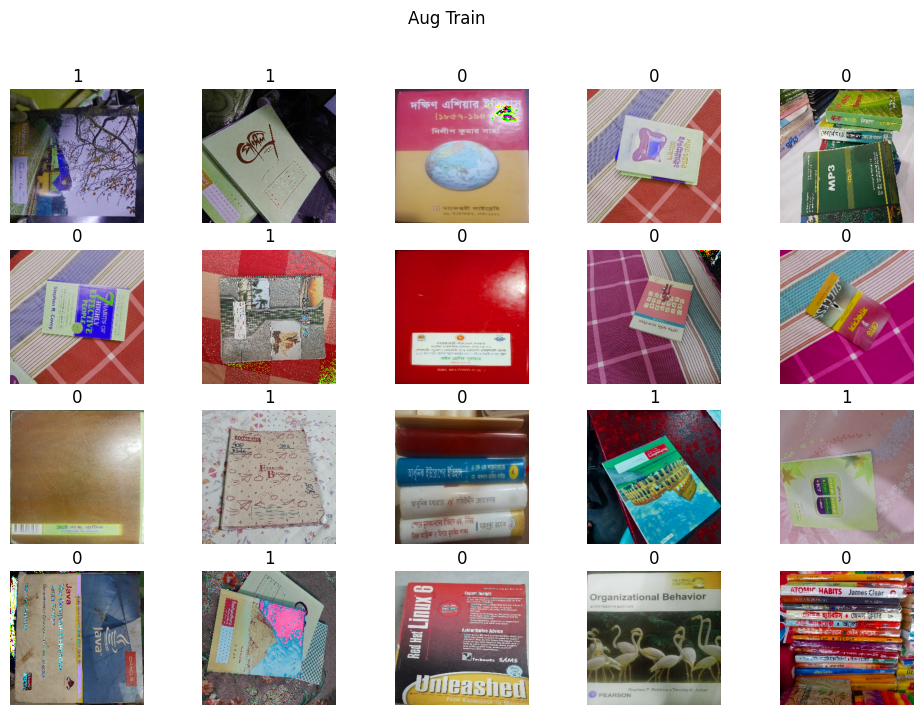

In [116]:
plot_images(aug_train, 'Aug Train')

# Merging the photometric augmented images to actual train and validation dataset

In [117]:
train_ds = train_ds.concatenate(aug_train)
val_ds = val_ds.concatenate(aug_val)

# Shuffling the datasets

In [118]:
train_ds = train_ds.shuffle(buffer_size=100000).prefetch(AUTOTUNE)
# val_ds = val_ds.shuffle(buffer_size=100000).prefetch(AUTOTUNE)

In [119]:
# aug_train = aug_train.shuffle(buffer_size=100000).prefetch(AUTOTUNE)
# plot_images(aug_train, 'Aug Train')

In [120]:
# plot_images(val_ds, 'Validation Dataset')

In [121]:
# plot_images(test_ds, 'Test Dataset')

In [122]:
# !pip install -q --upgrade keras-cv

In [123]:
# import keras_cv
# mix_up = keras_cv.layers.MixUp()
# cut_mix = keras_cv.layers.CutMix()

In [124]:
# def mix_up_f(images, labels):
#     labels = tf.one_hot(labels, 2)
#     labels = tf.cast(labels, tf.float32)
#     samples = {"images": images, "labels": labels}
#     samples = mix_up(samples, training=True)
#     return samples["images"], tf.cast(samples["labels"], tf.uint8)

In [125]:
# def cut_mix_f(images, labels):
#     labels = tf.one_hot(labels, 2)
#     labels = tf.cast(labels, tf.float32)
#     samples = {"images": images, "labels": labels}
#     samples = cut_mix(samples, training=True)
#     return samples["images"], tf.cast(samples["labels"], tf.uint8)

In [126]:
# def mix_up_cut_mix_augmentation(dataset):
#     mix_up_images = []
#     mix_up_labels = []

#     for images, labels in dataset:
#         labels = tf.argmax(labels, axis=-1)
#         labels = tf.cast(labels, tf.uint8)
#         images = tf.cast(images, tf.float16)
#         mix_up_images.append(images.numpy())
#         mix_up_labels.append(labels.numpy())

#     mix_up_images = np.concatenate(mix_up_images, axis=0)
#     mix_up_labels = np.concatenate(mix_up_labels, axis=0)
#     return tf.data.Dataset.from_tensor_slices((mix_up_images, mix_up_labels)).batch(batch_size)

In [127]:
# def mix_up_cut_mix(dataset, op):
#     ds=None
#     if op == "mix_up":
#         ds = dataset.map(lambda x, y : mix_up_f(x, y), num_parallel_calls=AUTOTUNE)
#     elif op == "cut_mix":
#         ds = dataset.map(lambda x, y : cut_mix_f(x, y), num_parallel_calls=AUTOTUNE)
#     return mix_up_cut_mix_augmentation(ds)

In [128]:
# mix_up_train = mix_up_cut_mix(tmp_train_ds, "mix_up")
# cut_mix_train = mix_up_cut_mix(tmp_train_ds, "cut_mix")

In [129]:
# mix_up_val = mix_up_cut_mix(tmp_val_ds, "mix_up")
# cut_mix_val = mix_up_cut_mix(tmp_val_ds, "cut_mix")

In [130]:
# plot_images(mix_up_train, 'Mix Up Dataset')

In [131]:
# plot_images(cut_mix_train, 'cut mix dataset')

In [132]:
# train_ds = train_ds.concatenate(mix_up_train)
# train_ds = train_ds.concatenate(cut_mix_train)

In [133]:
# val_ds = val_ds.concatenate(mix_up_val)
# val_ds = val_ds.concatenate(cut_mix_val)

In [134]:
# aug_train_cut_mix = mix_up_cut_mix(aug_train, "cut_mix")
# train_ds = train_ds.concatenate(aug_train_cut_mix)

In [135]:
# aug_val_cut_mix = mix_up_cut_mix(aug_val, "cut_mix")
# val_ds = val_ds.concatenate(aug_val_cut_mix)

In [136]:
# aug_train_mix_up = mix_up_cut_mix(aug_train, "mix_up")
# train_ds = train_ds.concatenate(aug_train_mix_up)

In [137]:
# aug_val_mix_up = mix_up_cut_mix(aug_val, "mix_up")
# val_ds = val_ds.concatenate(aug_val_mix_up)

In [138]:
# train_ds = train_ds.shuffle(buffer_size=100000).prefetch(AUTOTUNE)
# val_ds = val_ds.shuffle(buffer_size=100000).prefetch(AUTOTUNE)

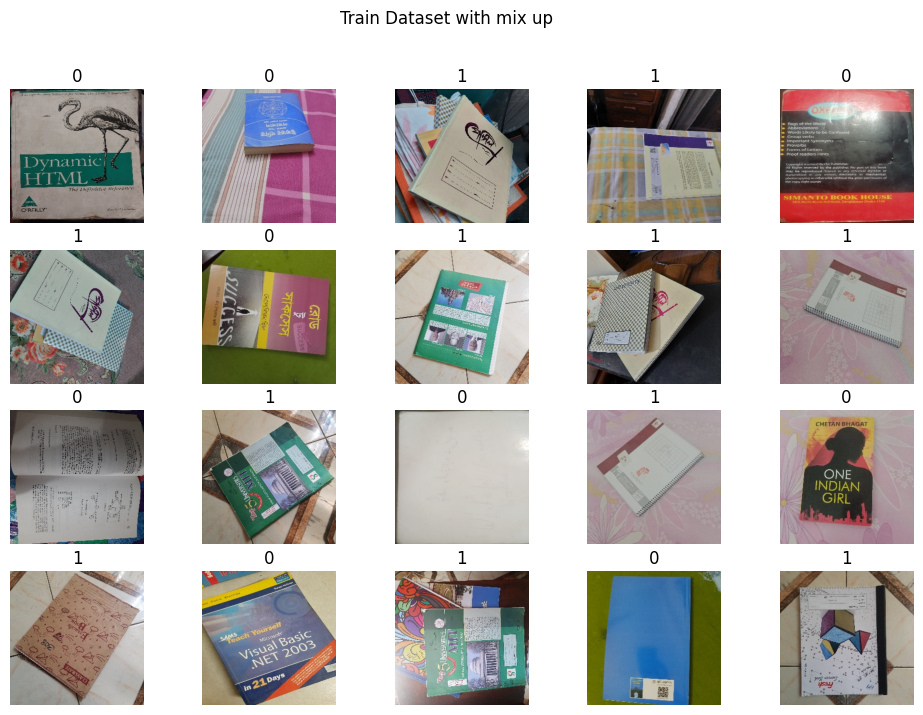

In [139]:
plot_images(train_ds, 'Train Dataset with mix up')

In [140]:
import gc
gc.collect()

89344

In [141]:
save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')

# FCNN Model

In [142]:
with strategy.scope():

    inputs = Input(shape=image_size + (3,))
    x = Flatten()(inputs)
    x = Dense(256, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    fc_model = keras.Model(inputs, outputs, name='FC_Model')
    fc_model.summary()
    
    fc_model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=BinaryCrossentropy(),
        metrics=[BinaryAccuracy(name='accuracy')]
    )

Model: "FC_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 196608)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │    50,331,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,808,449 (193.82 MB)

 Trainable params: 50,808,449 (193.82 MB)

 Non-trainable params: 0 (0.00 B)

In [143]:
class CustomLearningRateSchedule(tf.keras.callbacks.Callback):
    def __init__(self, initial_lr, decay_factor=0.1):
        super().__init__()
        self.initial_lr = initial_lr
        self.decay_factor = decay_factor

    def on_epoch_begin(self, epoch, logs=None):
            lr = self.model.optimizer.learning_rate
            lr = self.initial_lr * tf.exp(-self.decay_factor * epoch)
            self.model.optimizer.learning_rate = lr

In [144]:
# checkpoint_dir = './checkpoints'

# Training FCNN model

In [145]:
with strategy.scope():
#     tf.saved_model.save(fc_model, 'fc_model.keras', options=save_locally)

    history = fc_model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.9, patience=3, verbose=1),
        #             CustomLearningRateSchedule(decay_factor=lr_decay_factor, initial_lr=learning_rate),
                ModelCheckpoint('FC_Model.keras', save_weights_only=False, save_best_only=True, verbose=1),
                EarlyStopping(patience=15, restore_best_weights=True),
            ],
        )

Epoch 1/50


2024-07-30 16:17:59.305521: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1722356280.027447     815 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(c62cf120e62036b9:0:0), session_name()


  1/226 ━━━━━━━━━━━━━━━━━━━━ 5:43:41 92s/step - accuracy: 0.0000e+00 - loss: 42.9821

I0000 00:00:1722356361.313959     815 tpu_compile_op_common.cc:245] Compilation of c62cf120e62036b9:0:0 with session name  took 1m21.286462323s and succeeded
I0000 00:00:1722356361.317739     815 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(c62cf120e62036b9:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_3601274010201398464", property.function_library_fingerprint = 14515272988634372001, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,256,256,3,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722356361.317771     815 tpu_compilation_cache_interface.cc:541] After adding entry for key 

 10/226 ━━━━━━━━━━━━━━━━━━━━ 14:10 4s/step - accuracy: 0.4280 - loss: 116.7134  

I0000 00:00:1722356396.637775     812 tpu_compile_op_common.cc:245] Compilation of 3673e3f7698ce4d8:0:0 with session name  took 35.241950898s and succeeded
I0000 00:00:1722356396.642148     812 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(3673e3f7698ce4d8:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_3601274010201398464", property.function_library_fingerprint = 14515272988634372001, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,256,256,3,;2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722356396.642188     812 tpu_compilation_cache_interface.cc:541] After adding entry for key 36

225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.5545 - loss: 120.8711

2024-07-30 16:20:04.974544: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignVariableOp.
I0000 00:00:1722356405.169579     838 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(b0227b235947b4a2:0:0), session_name()
I0000 00:00:1722356485.910902     838 tpu_compile_op_common.cc:245] Compilation of b0227b235947b4a2:0:0 with session name  took 1m20.741258356s and succeeded
I0000 00:00:1722356485.912850     838 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(b0227b235947b4a2:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_6172910102307833872", property.function_library_fingerprint = 6810133498359286400, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, t


Epoch 1: val_loss improved from inf to 76.41281, saving model to FC_Model.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 257s 734ms/step - accuracy: 0.5549 - loss: 120.6821 - val_accuracy: 0.4910 - val_loss: 76.4128 - learning_rate: 1.0000e-04
Epoch 2/50
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6588 - loss: 61.2837
Epoch 2: val_loss did not improve from 76.41281
226/226 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.6587 - loss: 61.3342 - val_accuracy: 0.5197 - val_loss: 162.3799 - learning_rate: 1.0000e-04
Epoch 3/50
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7006 - loss: 41.6655
Epoch 3: val_loss improved from 76.41281 to 27.25594, saving model to FC_Model.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.7008 - loss: 41.5303 - val_accuracy: 0.4839 - val_loss: 27.2559 - learning_rate: 1.0000e-04
Epoch 4/50
224/226 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7634 - loss: 10.1952
Epoch 4: val_loss improved from 27.25594 to 25.14483, saving model to F

# FCNN graph comparisons

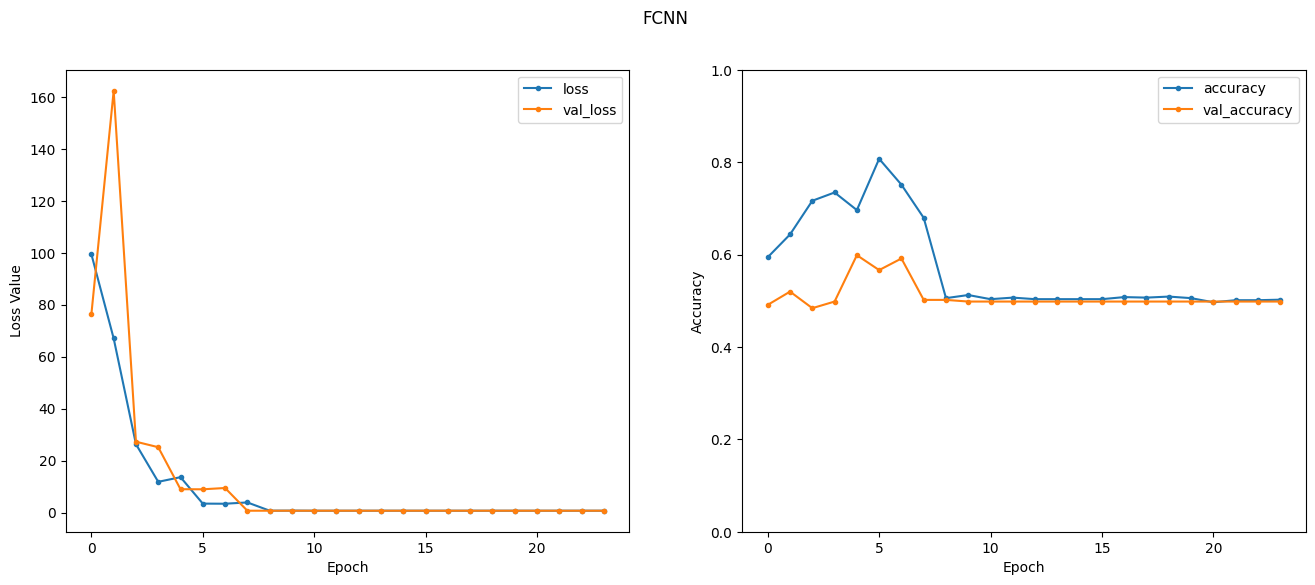

In [146]:
plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plt.suptitle('FCNN')
plt.plot(history.history['loss'], '.-')
plt.plot(history.history['val_loss'], '.-')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend(['loss', 'val_loss'])

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], '.-')
plt.plot(history.history['val_accuracy'], '.-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(['accuracy', 'val_accuracy'])

plt.show()

# Loading best FCNN checkpoints and compiling

In [147]:
with strategy.scope():

    fc_model = tf.keras.models.load_model('FC_Model.keras')

    fc_model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=BinaryCrossentropy(),
        metrics=[
            BinaryAccuracy(name='accuracy'),
            Precision(name='precision'),
            Recall(name='recall'),
            F1Score(name='f1score'),
        ]
    )

# Evaluating FCNN

In [148]:
with strategy.scope():

    eval = fc_model.evaluate(test_ds, return_dict=True)

    print(eval)

2024-07-30 16:27:40.686665: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add_12/ReadVariableOp.
I0000 00:00:1722356860.932727     819 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(6c9820746f6fc6d6:0:0), session_name()


5/5 ━━━━━━━━━━━━━━━━━━━━ 82s 20ms/step - accuracy: 0.8417 - f1score: 0.0741 - loss: 0.6730 - precision: 0.3333 - recall: 0.0417          
{'accuracy': 0.6499999761581421, 'f1score': 0.2222221940755844, 'loss': 0.6561118364334106, 'precision': 1.0, 'recall': 0.125}


I0000 00:00:1722356941.691206     819 tpu_compile_op_common.cc:245] Compilation of 6c9820746f6fc6d6:0:0 with session name  took 1m20.758426089s and succeeded
I0000 00:00:1722356941.693446     819 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(6c9820746f6fc6d6:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_7409334061407693337", property.function_library_fingerprint = 7761257307468243046, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,256,256,3,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722356941.693478     819 tpu_compilation_cache_interface.cc:541] After adding entry for key 6

In [149]:
gc.collect()

144993

# SCNN model

In [150]:
with strategy.scope():
    inputs = Input(shape=image_size + (3,))
    x = Conv2D(filters=128, kernel_size=5, padding='same', activation='relu')(inputs)
    x = Conv2D(filters=128, kernel_size=5, padding='same', activation='relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling2D()(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    cnn_model = Model(inputs, outputs, name='SCNN_Model')
    cnn_model.summary()
    
    cnn_model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss=BinaryCrossentropy(),
    metrics=[BinaryAccuracy(name='accuracy')])

Model: "SCNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 256, 256, 128)  │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 256, 256, 128)  │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,518,593 (40.13 MB)

 Trainable params: 10,518,593 (40.13 MB)

 Non-trainable params: 0 (0.00 B)

# Training SCNN model

In [151]:
with strategy.scope():
 
    history = cnn_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.9, patience=3, verbose=1),
#             CustomLearningRateSchedule(decay_factor=lr_decay_factor, initial_lr=learning_rate),
            ModelCheckpoint('SCNN_Model.keras', save_weights_only=False, save_best_only=True, verbose=1),
            EarlyStopping(patience=15, restore_best_weights=True),
        ],
    )

Epoch 1/50


2024-07-30 16:29:21.081003: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1722356961.913036     771 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(999dc7e5edf5589c:0:0), session_name()


  3/226 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.3194 - loss: 1.8345    

I0000 00:00:1722356969.264721     771 tpu_compile_op_common.cc:245] Compilation of 999dc7e5edf5589c:0:0 with session name  took 7.351631644s and succeeded
I0000 00:00:1722356969.273820     771 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(999dc7e5edf5589c:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_7381966523003223614", property.function_library_fingerprint = 6868040135801547078, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,256,256,3,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722356969.273860     771 tpu_compilation_cache_interface.cc:541] After adding entry for key 999d

  7/226 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.3845 - loss: 1.6761

I0000 00:00:1722356969.623879     766 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(1cde47ddfb59da91:0:0), session_name()


 11/226 ━━━━━━━━━━━━━━━━━━━━ 4:37 1s/step - accuracy: 0.4198 - loss: 1.5050

I0000 00:00:1722356982.102386     766 tpu_compile_op_common.cc:245] Compilation of 1cde47ddfb59da91:0:0 with session name  took 12.478454699s and succeeded
I0000 00:00:1722356982.111687     766 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(1cde47ddfb59da91:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_7381966523003223614", property.function_library_fingerprint = 6868040135801547078, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,256,256,3,;2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722356982.111724     766 tpu_compilation_cache_interface.cc:541] After adding entry for key 1cd

225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.5962 - loss: 0.7695

I0000 00:00:1722356995.762849     828 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(f2f038ffbed5aee0:0:0), session_name()
I0000 00:00:1722357000.230578     828 tpu_compile_op_common.cc:245] Compilation of f2f038ffbed5aee0:0:0 with session name  took 4.467671234s and succeeded
I0000 00:00:1722357000.233233     828 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(f2f038ffbed5aee0:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_10047937754722442443", property.function_library_fingerprint = 14565882682175132140, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,256,256,3,;4,;", property.guaranteed_constants_size = 0, embedd


Epoch 1: val_loss improved from inf to 0.64678, saving model to SCNN_Model.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 64s 189ms/step - accuracy: 0.5965 - loss: 0.7687 - val_accuracy: 0.5735 - val_loss: 0.6468 - learning_rate: 1.0000e-04
Epoch 2/50
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6930 - loss: 0.6442
Epoch 2: val_loss improved from 0.64678 to 0.60253, saving model to SCNN_Model.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - accuracy: 0.6925 - loss: 0.6443 - val_accuracy: 0.6703 - val_loss: 0.6025 - learning_rate: 1.0000e-04
Epoch 3/50
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7155 - loss: 0.5622
Epoch 3: val_loss did not improve from 0.60253
226/226 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - accuracy: 0.7156 - loss: 0.5622 - val_accuracy: 0.4910 - val_loss: 1.1806 - learning_rate: 1.0000e-04
Epoch 4/50
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7175 - loss: 0.5745
Epoch 4: val_loss did not improve from 0.60253
226/226 ━━━━━━━━━━━━━━━━━━━━ 19s 57m

# SCNN graph comparisons

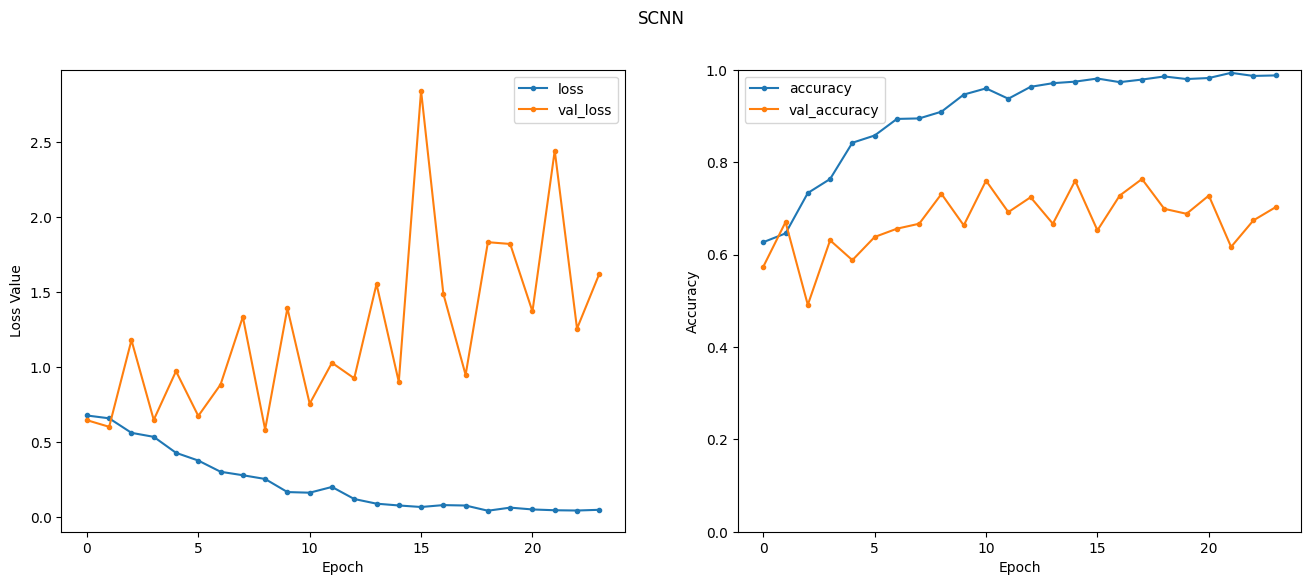

In [152]:
plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plt.suptitle('SCNN')
plt.plot(history.history['loss'], '.-')
plt.plot(history.history['val_loss'], '.-')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend(['loss', 'val_loss'])

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], '.-')
plt.plot(history.history['val_accuracy'], '.-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(['accuracy', 'val_accuracy'])

plt.show()

# Loading best SCNN checkpoints and compiling

In [153]:
with strategy.scope():
    
    cnn_model = tf.keras.models.load_model('SCNN_Model.keras')

    cnn_model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=BinaryCrossentropy(),
        metrics=[
            BinaryAccuracy(name='accuracy'),
            Precision(name='precision'),
            Recall(name='recall'),
            F1Score(name='f1score'),
        ]
    )

# Evaluating SCNN

In [154]:
with strategy.scope():
    
    eval = cnn_model.evaluate(test_ds, return_dict=True)

    print(eval)

2024-07-30 16:37:25.396467: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add_12/ReadVariableOp.
I0000 00:00:1722357445.657935     767 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(893e2d98df4932b4:0:0), session_name()


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9021 - f1score: 0.2889 - loss: 0.2340 - precision: 0.5000 - recall: 0.2083         
{'accuracy': 0.800000011920929, 'f1score': 0.6666666269302368, 'loss': 0.3670353889465332, 'precision': 1.0, 'recall': 0.5}


I0000 00:00:1722357450.621539     767 tpu_compile_op_common.cc:245] Compilation of 893e2d98df4932b4:0:0 with session name  took 4.963546283s and succeeded
I0000 00:00:1722357450.625320     767 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(893e2d98df4932b4:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_5701274658525193539", property.function_library_fingerprint = 6790558283712106349, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,256,256,3,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722357450.625354     767 tpu_compilation_cache_interface.cc:541] After adding entry for key 893e

# VGG16 Model

In [155]:
with strategy.scope():

    vgg16 = keras.applications.vgg16.VGG16(include_top=False, weights=None, input_shape=image_size+(3,))

    inputs = vgg16.input
    x = keras.layers.Flatten()(vgg16.output)
    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.Dense(128, activation='relu')(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    
    vgg16_model = Model(inputs, outputs, name='VGG16_Model')
    vgg16_model.summary()
    
    vgg16_model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss=BinaryCrossentropy(),
    metrics=[BinaryAccuracy(name='accuracy')])

Model: "VGG16_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,136,577 (88.26 MB)

 Trainable params: 23,136,577 (88.26 MB)

 Non-trainable params: 0 (0.00 B)

# Training VGG16(no weights) model

In [156]:
with strategy.scope():

    history = vgg16_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.9, patience=3, verbose=1),
#             CustomLearningRateSchedule(decay_factor=lr_decay_factor, initial_lr=learning_rate),
            ModelCheckpoint('VGG16_Model.keras', save_weights_only=False, save_best_only=True, verbose=1),
            EarlyStopping(patience=15, restore_best_weights=True),
        ],
    )

Epoch 1/50


I0000 00:00:1722357473.484014     826 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(84e8ea9e5e935f33:0:0), session_name()


  3/226 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.3194 - loss: 1.1096    

I0000 00:00:1722357481.786154     826 tpu_compile_op_common.cc:245] Compilation of 84e8ea9e5e935f33:0:0 with session name  took 8.302089243s and succeeded
I0000 00:00:1722357481.797093     826 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(84e8ea9e5e935f33:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_10251121073321658484", property.function_library_fingerprint = 9208860457391210095, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,256,256,3,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722357481.797129     826 tpu_compilation_cache_interface.cc:541] After adding entry for key 84e

 17/226 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.4039 - loss: 0.9319

I0000 00:00:1722357482.490859     779 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(8e4b96718dd2c103:0:0), session_name()


 22/226 ━━━━━━━━━━━━━━━━━━━━ 1:29 437ms/step - accuracy: 0.4134 - loss: 0.9006

I0000 00:00:1722357490.840007     779 tpu_compile_op_common.cc:245] Compilation of 8e4b96718dd2c103:0:0 with session name  took 8.349103395s and succeeded
I0000 00:00:1722357490.850084     779 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(8e4b96718dd2c103:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_10251121073321658484", property.function_library_fingerprint = 9208860457391210095, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,256,256,3,;2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722357490.850150     779 tpu_compilation_cache_interface.cc:541] After adding entry for key 8e4

226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5108 - loss: 0.7316

I0000 00:00:1722357503.414578     785 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(c94618fa6c2be4d4:0:0), session_name()
I0000 00:00:1722357510.067912     785 tpu_compile_op_common.cc:245] Compilation of c94618fa6c2be4d4:0:0 with session name  took 6.653286073s and succeeded
I0000 00:00:1722357510.071242     785 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(c94618fa6c2be4d4:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_11767956723787235711", property.function_library_fingerprint = 10344262976162208789, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,256,256,3,;4,;", property.guaranteed_constants_size = 0, embedd


Epoch 1: val_loss improved from inf to 0.69683, saving model to VGG16_Model.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 59s 153ms/step - accuracy: 0.5110 - loss: 0.7315 - val_accuracy: 0.4982 - val_loss: 0.6968 - learning_rate: 1.0000e-04
Epoch 2/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5704 - loss: 0.6913
Epoch 2: val_loss did not improve from 0.69683
226/226 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step - accuracy: 0.5705 - loss: 0.6913 - val_accuracy: 0.5484 - val_loss: 0.7253 - learning_rate: 1.0000e-04
Epoch 3/50
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6387 - loss: 0.6644
Epoch 3: val_loss improved from 0.69683 to 0.69227, saving model to VGG16_Model.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.6384 - loss: 0.6646 - val_accuracy: 0.5376 - val_loss: 0.6923 - learning_rate: 1.0000e-04
Epoch 4/50
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6497 - loss: 0.6902
Epoch 4: val_loss improved from 0.69227 to 0.65712, saving model to VGG16_Model.k

# VGG16(no weights) graph comparisons

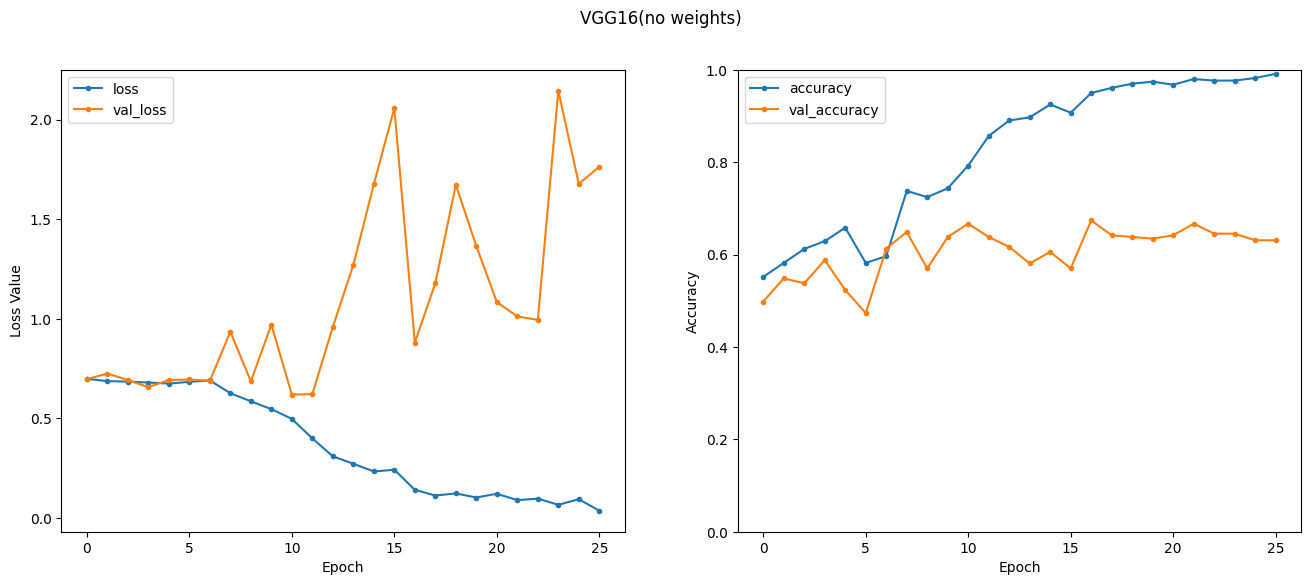

In [157]:
plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plt.suptitle('VGG16(no weights)')
plt.plot(history.history['loss'], '.-')
plt.plot(history.history['val_loss'], '.-')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend(['loss', 'val_loss'])

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], '.-')
plt.plot(history.history['val_accuracy'], '.-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(['accuracy', 'val_accuracy'])

plt.show()

# Loading best VGG16(no weights) checkpoints and compiling

In [158]:
with strategy.scope():
    
    vgg16_model = tf.keras.models.load_model('VGG16_Model.keras')

    vgg16_model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=BinaryCrossentropy(),
        metrics=[
            BinaryAccuracy(name='accuracy'),
            Precision(name='precision'),
            Recall(name='recall'),
            F1Score(name='f1score'),
        ]
    )

# Evaluating VGG16(no weights)

In [159]:
with strategy.scope():
    
    eval = vgg16_model.evaluate(test_ds, return_dict=True)

    print(eval)

2024-07-30 16:46:15.986350: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add_12/ReadVariableOp.
I0000 00:00:1722357976.254862     821 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(13cd21684a89b984:0:0), session_name()


5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.7500 - f1score: 0.3353 - loss: 0.4800 - precision: 0.3056 - recall: 0.3750         
{'accuracy': 0.75, 'f1score': 0.7058822512626648, 'loss': 0.4529287815093994, 'precision': 0.6666666865348816, 'recall': 0.75}


I0000 00:00:1722357982.459064     821 tpu_compile_op_common.cc:245] Compilation of 13cd21684a89b984:0:0 with session name  took 6.204138575s and succeeded
I0000 00:00:1722357982.462397     821 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(13cd21684a89b984:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_5375589206326425134", property.function_library_fingerprint = 7830498418510341984, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,256,256,3,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722357982.462427     821 tpu_compilation_cache_interface.cc:541] After adding entry for key 13cd

# VGG16 with imagenet weights

In [160]:
with strategy.scope():

    vgg16 = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=image_size+(3,))

    inputs = vgg16.input
    x = Flatten()(vgg16.output)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    vgg16_model = Model(inputs, outputs, name='VGG16_Model_Half_TL')
    vgg16_model.summary(show_trainable=True)
    
    base_vgg16_model = vgg16_model
    vgg16_model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=BinaryCrossentropy(),
        metrics=[BinaryAccuracy(name='accuracy')]
    )

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "VGG16_Model_Half_TL"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_5 (InputLayer)  │ (None, 256, 256, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv1 (Conv2D)       │ (None, 256, 256, 64)  │      1,792 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv2 (Conv2D)       │ (None, 256, 256, 64)  │     36,928 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_pool (MaxPooling2D)  │ (None, 128, 128, 64)  │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv1 (Conv2D)       │ (None, 128, 128, 128) │     73,856 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv2 (Conv2D)       │ (None, 128, 128, 128) │    147,584 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_pool (MaxPooling2D)  │ (None, 64, 64, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv1 (Conv2D)       │ (None, 64, 64, 256)   │    295,168 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv2 (Conv2D)       │ (None, 64, 64, 256)   │    590,080 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv3 (Conv2D)       │ (None, 64, 64, 256)   │    590,080 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_pool (MaxPooling2D)  │ (None, 32, 32, 256)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv1 (Conv2D)       │ (None, 32, 32, 512)   │  1,180,160 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv2 (Conv2D)       │ (None, 32, 32, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv3 (Conv2D)       │ (None, 32, 32, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_pool (MaxPooling2D)  │ (None, 16, 16, 512)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv1 (Conv2D)       │ (None, 16, 16, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv2 (Conv2D)       │ (None, 16, 16, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv3 (Conv2D)       │ (None, 16, 16, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_pool (MaxPooling2D)  │ (None, 8, 8, 512)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_5 (Flatten)         │ (None, 32768)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_21 (Dense)            │ (None, 256)           │  8,388,864 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_22 (Dense)            │ (None, 128)           │     32,896 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_23 (Dense)            │ (None, 1)             │        129 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 23,136,577 (88.26 MB)

 Trainable params: 23,136,577 (88.26 MB)

 Non-trainable params: 0 (0.00 B)

# Freezing all the layers except the last 4

In [161]:
with strategy.scope():

    for layer in vgg16_model.layers[:-4]:
      layer.trainable = False
    vgg16_model.summary(show_trainable=True)

Model: "VGG16_Model_Half_TL"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_5 (InputLayer)  │ (None, 256, 256, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv1 (Conv2D)       │ (None, 256, 256, 64)  │      1,792 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv2 (Conv2D)       │ (None, 256, 256, 64)  │     36,928 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_pool (MaxPooling2D)  │ (None, 128, 128, 64)  │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv1 (Conv2D)       │ (None, 128, 128, 128) │     73,856 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv2 (Conv2D)       │ (None, 128, 128, 128) │    147,584 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_pool (MaxPooling2D)  │ (None, 64, 64, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv1 (Conv2D)       │ (None, 64, 64, 256)   │    295,168 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv2 (Conv2D)       │ (None, 64, 64, 256)   │    590,080 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv3 (Conv2D)       │ (None, 64, 64, 256)   │    590,080 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_pool (MaxPooling2D)  │ (None, 32, 32, 256)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv1 (Conv2D)       │ (None, 32, 32, 512)   │  1,180,160 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv2 (Conv2D)       │ (None, 32, 32, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv3 (Conv2D)       │ (None, 32, 32, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_pool (MaxPooling2D)  │ (None, 16, 16, 512)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv1 (Conv2D)       │ (None, 16, 16, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv2 (Conv2D)       │ (None, 16, 16, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv3 (Conv2D)       │ (None, 16, 16, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_pool (MaxPooling2D)  │ (None, 8, 8, 512)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_5 (Flatten)         │ (None, 32768)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_21 (Dense)            │ (None, 256)           │  8,388,864 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_22 (Dense)            │ (None, 128)           │     32,896 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_23 (Dense)            │ (None, 1)             │        129 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 23,136,577 (88.26 MB)

 Trainable params: 8,421,889 (32.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# Apply Preprocessing Function
#### Since we are using pretrained weights, we need to preprocess our inputs with an appropiate preprocessing function. One way of doing this is to map the preprocessing function to the dataset object.

In [162]:
prep_train_ds = train_ds.map(lambda x, y: (keras.applications.vgg16.preprocess_input(x), y))
prep_val_ds = val_ds.map(lambda x, y: (keras.applications.vgg16.preprocess_input(x), y))
prep_test_ds = test_ds.map(lambda x, y: (keras.applications.vgg16.preprocess_input(x), y))

# Training VGG16 with imagenet and freezed layers

In [163]:
with strategy.scope():

    history = vgg16_model.fit(
        prep_train_ds,
        validation_data=prep_val_ds,
        epochs=epochs,
        callbacks=[
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1),
#             CustomLearningRateSchedule(decay_factor=lr_decay_factor, initial_lr=learning_rate),
            ModelCheckpoint('VGG16_Model_Half_TL.keras', save_weights_only=False, save_best_only=True, verbose=1),
            EarlyStopping(patience=15, restore_best_weights=True),
        ],
    )

Epoch 1/50


I0000 00:00:1722358000.242067     821 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(2a0ce2734e863f76:0:0), session_name()


  7/226 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.5377 - loss: 3.3697   

I0000 00:00:1722358006.764472     821 tpu_compile_op_common.cc:245] Compilation of 2a0ce2734e863f76:0:0 with session name  took 6.522359793s and succeeded
I0000 00:00:1722358006.768212     821 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(2a0ce2734e863f76:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_18398543415832325563", property.function_library_fingerprint = 2304171491552189724, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,256,256,3,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722358006.768241     821 tpu_compilation_cache_interface.cc:541] After adding entry for key 2a0

 28/226 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.6626 - loss: 2.3909

I0000 00:00:1722358007.418858     804 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(cf470b5c353c411c:0:0), session_name()


 36/226 ━━━━━━━━━━━━━━━━━━━━ 25s 132ms/step - accuracy: 0.6896 - loss: 2.1579

I0000 00:00:1722358011.255464     804 tpu_compile_op_common.cc:245] Compilation of cf470b5c353c411c:0:0 with session name  took 3.836541764s and succeeded
I0000 00:00:1722358011.260193     804 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(cf470b5c353c411c:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_18398543415832325563", property.function_library_fingerprint = 2304171491552189724, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,256,256,3,;2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722358011.260223     804 tpu_compilation_cache_interface.cc:541] After adding entry for key cf4

224/226 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8513 - loss: 0.9372

I0000 00:00:1722358020.104152     780 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(dd1f7280c0dae3ff:0:0), session_name()
I0000 00:00:1722358026.142501     780 tpu_compile_op_common.cc:245] Compilation of dd1f7280c0dae3ff:0:0 with session name  took 6.03826773s and succeeded
I0000 00:00:1722358026.145291     780 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(dd1f7280c0dae3ff:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_12819839203488979252", property.function_library_fingerprint = 11860266850273031847, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,256,256,3,;4,;", property.guaranteed_constants_size = 0, embeddi


Epoch 1: val_loss improved from inf to 1.79289, saving model to VGG16_Model_Half_TL.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 42s 112ms/step - accuracy: 0.8523 - loss: 0.9312 - val_accuracy: 0.8495 - val_loss: 1.7929 - learning_rate: 1.0000e-04
Epoch 2/50
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9812 - loss: 0.0758
Epoch 2: val_loss did not improve from 1.79289
226/226 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9812 - loss: 0.0759 - val_accuracy: 0.8244 - val_loss: 2.4158 - learning_rate: 1.0000e-04
Epoch 3/50
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9960 - loss: 0.0119
Epoch 3: val_loss did not improve from 1.79289
226/226 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9960 - loss: 0.0118 - val_accuracy: 0.8423 - val_loss: 1.9141 - learning_rate: 1.0000e-04
Epoch 4/50
224/226 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9896 - loss: 0.1241
Epoch 4: ReduceLROnPlateau reducing learning rate to 8.999999772640876e-05.

Epoch 4: val_loss did not improve f

# VGG16 with imagenet and freezed layers graph comparisons

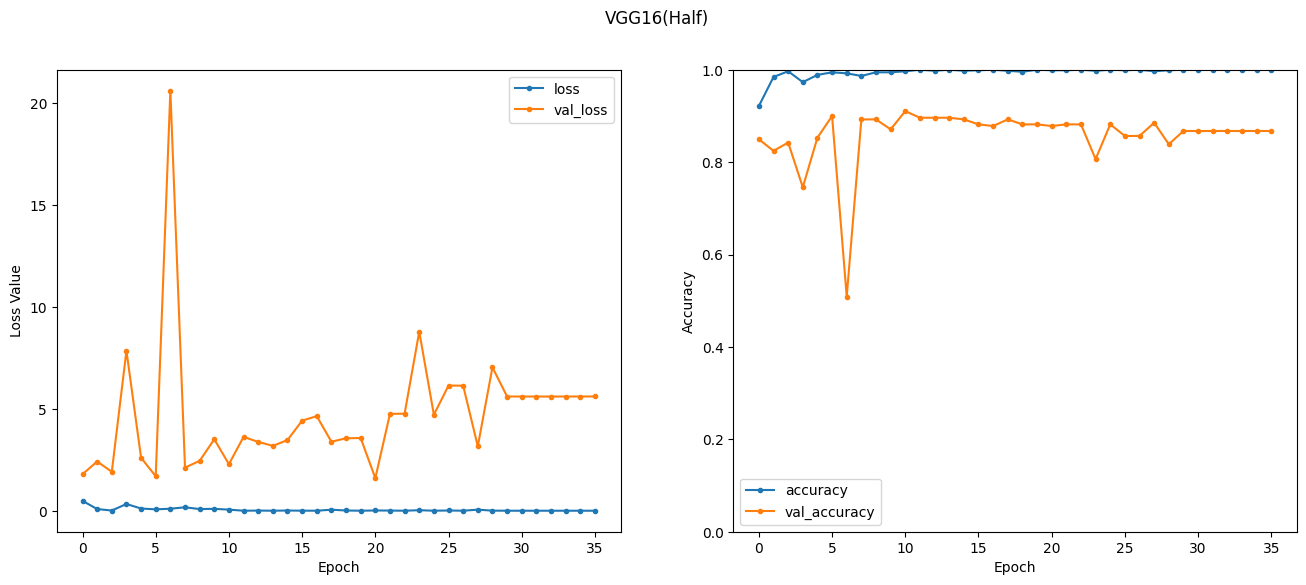

In [164]:
plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plt.suptitle('VGG16(Half)')
plt.plot(history.history['loss'], '.-')
plt.plot(history.history['val_loss'], '.-')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend(['loss', 'val_loss'])

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], '.-')
plt.plot(history.history['val_accuracy'], '.-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(['accuracy', 'val_accuracy'])

plt.show()

# Loading best VGG16 with imagenet and freezed layers checkpoints and compiling

In [165]:
with strategy.scope():
    
    vgg16_model = tf.keras.models.load_model('VGG16_Model_Half_TL.keras')

    vgg16_model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=BinaryCrossentropy(),
        metrics=[
            BinaryAccuracy(name='accuracy'),
            Precision(name='precision'),
            Recall(name='recall'),
            F1Score(name='f1score'),
        ]
    )

# Evaluating VGG16 with imagenet and freezed layers

In [166]:
with strategy.scope():
    
    eval = vgg16_model.evaluate(prep_test_ds, return_dict=True)

    print(eval)

2024-07-30 16:55:38.018184: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add_12/ReadVariableOp.
I0000 00:00:1722358538.364073     751 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(782c2f20eff15e15:0:0), session_name()


5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.7319 - f1score: 0.3778 - loss: 6.8440 - precision: 0.3056 - recall: 0.5000         
{'accuracy': 0.800000011920929, 'f1score': 0.7999999523162842, 'loss': 4.380797386169434, 'precision': 0.6666666865348816, 'recall': 1.0}


I0000 00:00:1722358544.626566     751 tpu_compile_op_common.cc:245] Compilation of 782c2f20eff15e15:0:0 with session name  took 6.262389583s and succeeded
I0000 00:00:1722358544.629758     751 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(782c2f20eff15e15:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_7881456407151609313", property.function_library_fingerprint = 14352723041237375962, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,256,256,3,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722358544.629788     751 tpu_compilation_cache_interface.cc:541] After adding entry for key 782

# Unfreezing all the layers and train them all

In [167]:
with strategy.scope():

    for layer in vgg16_model.layers:
      layer.trainable = True
    vgg16_model.summary(show_trainable=True)

Model: "VGG16_Model_Half_TL"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_5 (InputLayer)  │ (None, 256, 256, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv1 (Conv2D)       │ (None, 256, 256, 64)  │      1,792 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv2 (Conv2D)       │ (None, 256, 256, 64)  │     36,928 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_pool (MaxPooling2D)  │ (None, 128, 128, 64)  │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv1 (Conv2D)       │ (None, 128, 128, 128) │     73,856 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv2 (Conv2D)       │ (None, 128, 128, 128) │    147,584 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_pool (MaxPooling2D)  │ (None, 64, 64, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv1 (Conv2D)       │ (None, 64, 64, 256)   │    295,168 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv2 (Conv2D)       │ (None, 64, 64, 256)   │    590,080 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv3 (Conv2D)       │ (None, 64, 64, 256)   │    590,080 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_pool (MaxPooling2D)  │ (None, 32, 32, 256)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv1 (Conv2D)       │ (None, 32, 32, 512)   │  1,180,160 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv2 (Conv2D)       │ (None, 32, 32, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv3 (Conv2D)       │ (None, 32, 32, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_pool (MaxPooling2D)  │ (None, 16, 16, 512)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv1 (Conv2D)       │ (None, 16, 16, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv2 (Conv2D)       │ (None, 16, 16, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv3 (Conv2D)       │ (None, 16, 16, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_pool (MaxPooling2D)  │ (None, 8, 8, 512)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_5 (Flatten)         │ (None, 32768)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_21 (Dense)            │ (None, 256)           │  8,388,864 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_22 (Dense)            │ (None, 128)           │     32,896 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_23 (Dense)            │ (None, 1)             │        129 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 23,136,577 (88.26 MB)

 Trainable params: 23,136,577 (88.26 MB)

 Non-trainable params: 0 (0.00 B)

# Training VGG16(FULL) model

In [168]:
with strategy.scope():

    base_vgg16_model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=BinaryCrossentropy(),
        metrics=[BinaryAccuracy(name='accuracy')]
    )
    
    history = base_vgg16_model.fit(
        prep_train_ds,
        validation_data=prep_val_ds,
        epochs=epochs,
        callbacks=[
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1),
#             CustomLearningRateSchedule(decay_factor=lr_decay_factor, initial_lr=learning_rate),
            ModelCheckpoint('VGG16_Model_Full_TL.keras', save_weights_only=False, save_best_only=True, verbose=1),
            EarlyStopping(patience=15, restore_best_weights=True),
        ],
    )

Epoch 1/50


I0000 00:00:1722358558.640482     775 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(e0591a2ff327e42a:0:0), session_name()


  7/226 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 1.0000 - loss: 5.4834e-07 

I0000 00:00:1722358564.843117     775 tpu_compile_op_common.cc:245] Compilation of e0591a2ff327e42a:0:0 with session name  took 6.202585844s and succeeded
I0000 00:00:1722358564.846770     775 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(e0591a2ff327e42a:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_9932116594681504215", property.function_library_fingerprint = 12728284295623169898, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,256,256,3,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722358564.846799     775 tpu_compilation_cache_interface.cc:541] After adding entry for key e05

 16/226 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 1.0000 - loss: 9.9817e-04

I0000 00:00:1722358565.225219     834 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(2198f79ed499b9b1:0:0), session_name()


 24/226 ━━━━━━━━━━━━━━━━━━━━ 38s 188ms/step - accuracy: 0.9970 - loss: 0.0121

I0000 00:00:1722358569.060154     834 tpu_compile_op_common.cc:245] Compilation of 2198f79ed499b9b1:0:0 with session name  took 3.834884499s and succeeded
I0000 00:00:1722358569.064772     834 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(2198f79ed499b9b1:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_9932116594681504215", property.function_library_fingerprint = 12728284295623169898, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,256,256,3,;2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722358569.064808     834 tpu_compilation_cache_interface.cc:541] After adding entry for key 219

226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9958 - loss: 0.0221
Epoch 1: val_loss improved from inf to 6.48461, saving model to VGG16_Model_Full_TL.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 31s 68ms/step - accuracy: 0.9958 - loss: 0.0221 - val_accuracy: 0.8674 - val_loss: 6.4846 - learning_rate: 1.0000e-04
Epoch 2/50
224/226 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 1.0649e-09
Epoch 2: val_loss improved from 6.48461 to 6.42727, saving model to VGG16_Model_Full_TL.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 1.0000 - loss: 1.0660e-09 - val_accuracy: 0.8638 - val_loss: 6.4273 - learning_rate: 1.0000e-04
Epoch 3/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9994 - loss: 0.0043
Epoch 3: val_loss did not improve from 6.42727
226/226 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.9994 - loss: 0.0045 - val_accuracy: 0.8638 - val_loss: 8.3228 - learning_rate: 1.0000e-04
Epoch 4/50
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.995

# VGG16(Full) graph comparisons

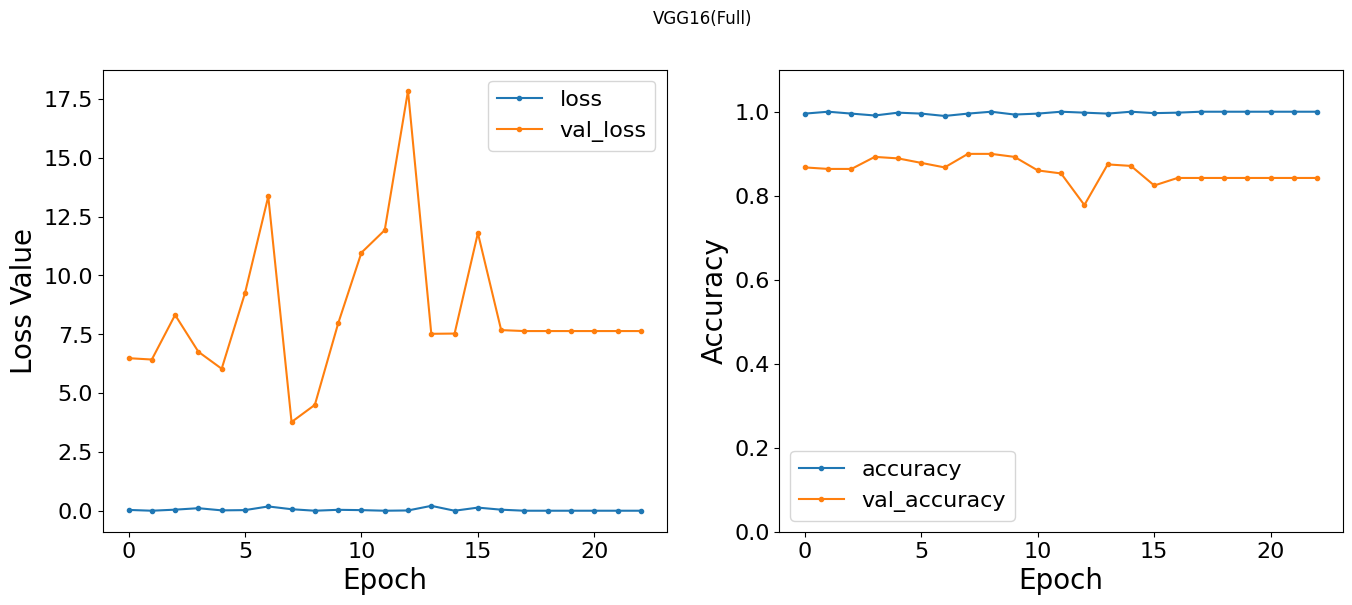

In [169]:
plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plt.suptitle('VGG16(Full)')
plt.plot(history.history['loss'], '.-')
plt.plot(history.history['val_loss'], '.-')
plt.xlabel('Epoch', fontsize=20)
plt.xticks(fontsize=16)
plt.ylabel('Loss Value',fontsize=20)
plt.yticks(fontsize=16)
plt.legend(['loss', 'val_loss'],fontsize=16)

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], '.-')
plt.plot(history.history['val_accuracy'], '.-')
plt.xlabel('Epoch',fontsize=20)
plt.xticks(fontsize=16)
plt.ylabel('Accuracy',fontsize=20)
plt.yticks(fontsize=16)
plt.ylim([0, 1.1])
plt.legend(['accuracy', 'val_accuracy'],fontsize=16)

# plt.savefig("./{}.eps".format('vgg-c-2'), bbox_inches='tight', format='eps', dpi=1000)
plt.show()

# Loading best VGG16(Full) checkpoints and compiling

In [170]:
with strategy.scope():
    
    vgg16_model = tf.keras.models.load_model('VGG16_Model_Full_TL.keras')

    vgg16_model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=BinaryCrossentropy(),
        metrics=[
            BinaryAccuracy(name='accuracy'),
            Precision(name='precision'),
            Recall(name='recall'),
            F1Score(name='f1score'),
        ]
    )

# Evaluating VGG16(Full)

In [171]:
with strategy.scope():
    
    eval = vgg16_model.evaluate(prep_test_ds, return_dict=True)

    print(eval)

2024-07-30 17:01:29.072949: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add_12/ReadVariableOp.
I0000 00:00:1722358889.473039     774 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(19c75c121b25fbc3:0:0), session_name()


5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.8694 - f1score: 0.4167 - loss: 4.4312 - precision: 0.4167 - recall: 0.4167         


I0000 00:00:1722358895.827128     774 tpu_compile_op_common.cc:245] Compilation of 19c75c121b25fbc3:0:0 with session name  took 6.354023263s and succeeded
I0000 00:00:1722358895.829907     774 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(19c75c121b25fbc3:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_16745170057441375784", property.function_library_fingerprint = 1280526216412155023, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,256,256,3,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722358895.829937     774 tpu_compilation_cache_interface.cc:541] After adding entry for key 19c

{'accuracy': 0.8999999761581421, 'f1score': 0.8749999403953552, 'loss': 7.602993965148926, 'precision': 0.875, 'recall': 0.875}
